# Instructions
- Create a list of frequency wins, which contains a 10,000 frequency of win for threshold = 15.
    - Using the duel_play function from the previous milestone, simulate the play for threshold = 15 against an opponent, whose strategy is chosen randomly among thresholds of 13, 14, 16, and 17.
    - Simulate this play 1,000 times, and at the end, calculate the win rate for threshold = 15 for non-tie cases. For example, in a game with 300 wins and 100 tie cases, the win rate would be 300/(1,000-100) = 0.33.
    - Repeat the calculation in the previous step 10,000 times and append the results to the list called "frequency_wins".
- Visualize the histogram of the winners list.
    - Check the distribution of the win probability histogram.
- Calculate the 95% confidence interval for the frequency_wins list.

The mean win rate is 0.51 and the 95% confidence interval is [0.48, 0.55]


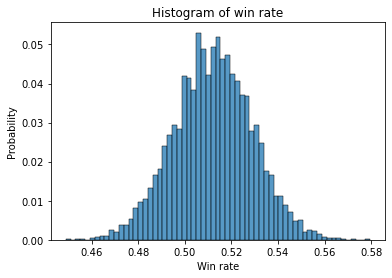

In [1]:
# %load calculate_confidence_intervals.py
import random
import statistics
import seaborn as sb
from scipy import stats
from itertools import product, chain
import matplotlib.pyplot as plt

random.seed(0)

THRESHOLD = 15


def create_deck():
    """
    Create a list that represents the card deck

    Cards are represented by a number according to the following rules:
    - Cards from 2 to 10 are represented by their number
    - Jacks, Queens, and Kings (court cards) are represented by the number 10
    - Aces are represented by 11

    Card suits (clubs, diamonds, hearts, and spades) don't matter in the game, so they're not recorded.
    """
    numeric_cards = range(2,11)
    value_court_cards = 10
    n_court_cards = 3
    value_ace = 11

    cards_in_a_suit = list(numeric_cards) + [value_court_cards]*n_court_cards + [value_ace]
    deck = 4 * cards_in_a_suit

    return deck


def alter_ace(hand):
    """
    Changes an ace from 11 to 1
    """
    hand.remove(11)
    hand.append(1)
    return hand


def simulate_one_game(deck, threshold):
    hand = [deck.pop(), deck.pop()]

    # there are exactly 2 aces
    # so use use of them as 1 instead of 11
    if sum(hand) == 22:
        hand = alter_ace(hand)

    while sum(hand) < threshold:
        hand.append(deck.pop())
        if sum(hand) > 21 and 11 in hand:
            hand = alter_ace(hand)
    
    return hand


def duel_play(threshold_1, threshold_2):
    """
    Simulate 2 strategies playing against each other
    
    Each strategy can have a different threshold for stopping.
    Cards are dealt first to one player until it finishes its game and then to the second.
    """
    deck = create_deck()
    random.shuffle(deck)
    
    sum_1 = sum(simulate_one_game(deck, threshold_1))
    sum_2 = sum(simulate_one_game(deck, threshold_2))

    winner = None

    if (sum_1 > 21 and sum_2 > 21) or sum_1 == sum_2:
        winner = 0
    elif sum_2 > 21:
        winner = threshold_1
    elif sum_1 > 21:
        winner = threshold_2
    # here I already know that both are smaller than 21 so I can check one against the other
    elif sum_1 > sum_2:
        winner = threshold_1
    elif sum_2 > sum_1:
        # or could be simply else I believe, but I'm being explicit
        winner = threshold_2
    return winner


def play_against_random_strategy(threshold, other_strategies=None):
    if other_strategies is None:
        other_strategies = [13, 14, 16, 17]
    opponent_threshold = random.choice(other_strategies)
    winner = duel_play(threshold, opponent_threshold)
    return winner


def simulate_n_individual_random_rounds(n_rounds):
    winners = [play_against_random_strategy(THRESHOLD) for _ in range(n_rounds)]
    winners_non_zero = [x for x in winners if x != 0]
    n_wins = len([x for x in winners if x == THRESHOLD])
    win_rate = n_wins / len(winners_non_zero)
    return win_rate


def repeat_simulation_m_times(n, m):
    """
    Simulate n games, repeating it m times for a total of n*m times with m output values
    """
    win_rates = [simulate_n_individual_random_rounds(n) for _ in range(m)]
    sb.histplot(win_rates, stat='probability')
    plt.xlabel('Win rate')
    plt.title('Histogram of win rate')
    return win_rates


def calculate_confidence_interval(win_rates):
    """
    Calculate confidence interval assuming the distribution is normal
    """
    alpha = .95
    mean_wins = statistics.mean(win_rates)
    confidence_interval = stats.norm.interval(alpha, mean_wins, statistics.stdev(win_rates))

    print(f'The mean win rate is {mean_wins:.2f} and the '\
          f'{alpha:.0%} confidence interval is [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')


if __name__ == '__main__':
    win_rates = repeat_simulation_m_times(1000, 10000)
    calculate_confidence_interval(win_rates)